In [2]:
import gurobipy as gp
from gurobipy import GRB
from typing import Dict
from pathlib import Path
from matplotlib import pyplot as plt

Sets

In [3]:
L = {"LW", "LE", "K", "M", "B", "S", "RH"}

T = set()

for t in range(0, 120, 5):
    T.add(f"{4+int(t/60)}_{(t%60):02}")

TR = set([*range(1,15,1)])

Parameters

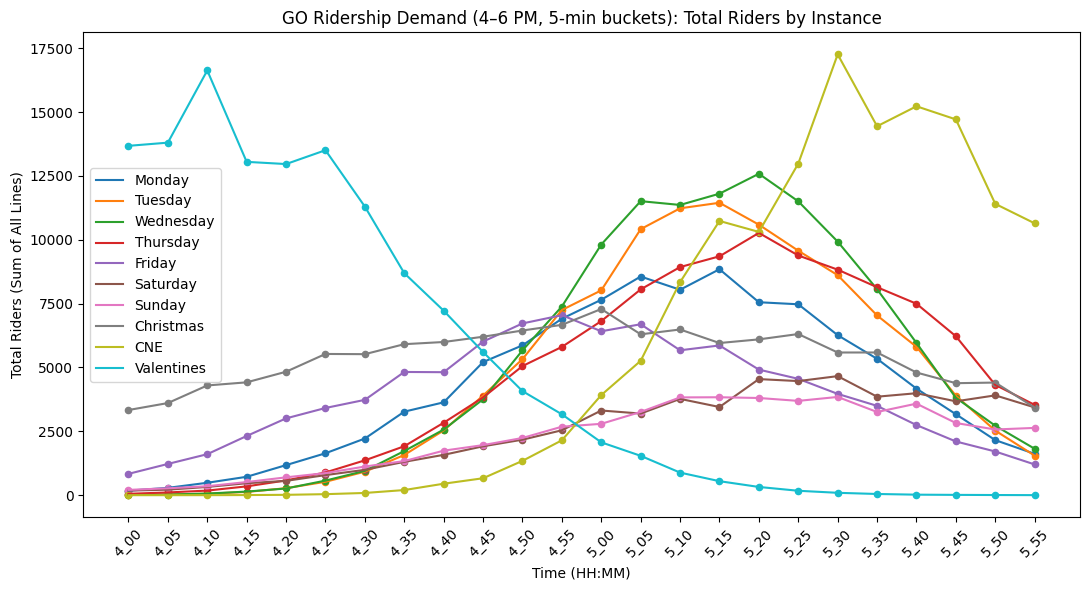

Instance 'instances/scenario_monday.json' created and saved.
Instance 'instances/scenario_tuesday.json' created and saved.
Instance 'instances/scenario_wednesday.json' created and saved.
Instance 'instances/scenario_thursday.json' created and saved.
Instance 'instances/scenario_friday.json' created and saved.
Instance 'instances/scenario_saturday.json' created and saved.
Instance 'instances/scenario_sunday.json' created and saved.
Instance 'instances/scenario_christmas.json' created and saved.
Instance 'instances/scenario_cne.json' created and saved.
Instance 'instances/scenario_valentines.json' created and saved.


In [4]:
%run ./ProbIns.ipynb

In [5]:
DEMAND = get_instances()
S = 162
C_MAX = 12
L_MAX = 80
C_TOTAL = 756
TR_MAX = 14

In [6]:
#Function for running one scenario

def run_scenario(scenario_name: str, scenario: Dict[str, Dict[str, int]], ):

    #Model

    model = gp.Model(f"{scenario_name}_MIP")
    model.Params.OutputFlag = 0

    #Decision vars

    X = model.addVars(L, TR, T, lb=0, ub=12, obj=0, vtype=GRB.INTEGER, name="X")
    P = model.addVars(L, TR, T, lb=0, obj=0, vtype=GRB.INTEGER, name="P")
    Y = model.addVars(L, TR, T, obj=0, vtype=GRB.BINARY, name="Y")
    U = model.addVars(L, T, lb=0, obj=1, vtype=GRB.INTEGER, name="U")

    #Constraints

    #Unmet Demand Constraint

    model.addConstrs(
        (U[l, t] >= scenario[l][t] - gp.quicksum(P[l, tr, t] for tr in TR)
        for l in L for t in T),
        name="UnmetDemand"
    )

    #Passenger Allocation Constraint

    model.addConstrs(
        (P[l, tr, t] <= S * X[l, tr, t]
        for l in L for tr in TR for t in T),
        name="PassengerAllocation"
    )

    #Platform Usage Limit

    model.addConstrs(
        ( gp.quicksum(Y[l, tr, t] for l in L for tr in TR) <= TR_MAX
        for t in T),
        name="PlatformUsage"
    )

    #Platform - Coach Links

    model.addConstrs(
        ( X[l, tr, t] <= C_MAX * Y[l, tr, t]
        for l in L for tr in TR for t in T),
        name="Platform-CoachLink"
    )

    #Locomotive Limit

    model.addConstr(
        ( gp.quicksum(Y[l, tr, t] for l in L for tr in TR for t in T) <= L_MAX
        ),
        name="LocomotiveLimit"
    )

    #Total Coach Limit

    model.addConstr(
        ( gp.quicksum(X[l, tr, t] for l in L for tr in TR for t in T) <= C_TOTAL
        ),
        name="CoachLimit"
    )

    model.update()

    #Set objective and solve

    model.modelSense = gp.GRB.MINIMIZE
    model.optimize()

    #Results

    optimized_value = model.ObjVal

    #Save model
    save_path = Path("./scenario_models")
    save_path.mkdir(parents = True, exist_ok = True)
    model.write((save_path/f"{scenario_name}_model.lp").as_posix())

    #Getting variable values
    vars = model.getVars()
    binary_vars = [v for v in vars if v.VType == GRB.BINARY]
    coach_vars = [v for v in vars if "X[" in v.VarName]
    passenger_vars = [v for v in vars if "P[" in v.VarName]

    loc_used = sum(model.getAttr("X", binary_vars))
    coaches_used = sum(model.getAttr("X", coach_vars))
    passengers_serviced = sum(model.getAttr("X", passenger_vars))

    #Total initial demand
    total_demand = 0
    for line in scenario.values():
        total_demand += sum([*line.values()])

    #Demand met
    demand_met = 100*(passengers_serviced/total_demand)

    #Return vars
    return scenario_name, optimized_value, loc_used, coaches_used, passengers_serviced, total_demand, round(demand_met, 2)


In [7]:
#Getting results

results = {}

for name, scenario in DEMAND.items():
    results[name]=run_scenario(name, scenario)

Set parameter Username
Set parameter LicenseID to value 2734228
Academic license - for non-commercial use only - expires 2026-11-07


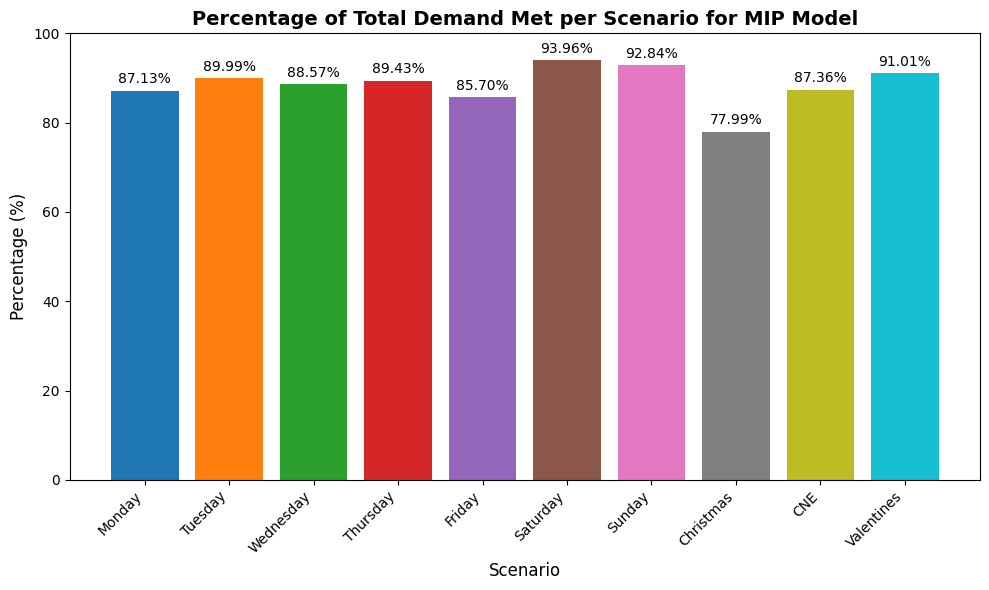

In [ ]:
#Graph results

scenarios = list(results.keys())
percentages = [v[-1] for v in results.values()]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(scenarios, percentages, color=plt.cm.tab10.colors)  # unique colors

# Labels and title
plt.title("Percentage of Total Demand Met per Scenario for MIP Model", fontsize=14, fontweight='bold')
plt.xlabel("Scenario", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, 100)  # ensure max 100
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar, val in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [9]:
results

{'Monday': ('Monday', 20206.0, 80.0, 551.0, 89262.0, 102444, 87.13),
 'Tuesday': ('Tuesday', 18009.0, 80.0, 629.0, 101898.0, 113228, 89.99),
 'Wednesday': ('Wednesday', 20729.0, 80.0, 678.0, 109836.0, 124011, 88.57),
 'Thursday': ('Thursday', 20375.0, 80.0, 631.0, 102222.0, 114305, 89.43),
 'Friday': ('Friday', 21505.0, 80.0, 502.0, 81324.0, 94895, 85.7),
 'Saturday': ('Saturday', 9723.0, 80.0, 344.0, 55728.0, 59310, 93.96),
 'Sunday': ('Sunday', 9732.0, 80.0, 309.0, 50058.0, 53917, 92.84),
 'Christmas': ('Christmas', 34083.0, 80.0, 623.0, 100926.0, 129403, 77.99),
 'CNE': ('CNE', 20114.0, 80.0, 756.0, 122472.0, 140187, 87.36),
 'Valentines': ('Valentines', 17751.0, 80.0, 727.0, 117774.0, 129403, 91.01)}

In [15]:
heuristic = [74950, 75436, 75274, 75760, 75436, 75922, 74626, 74788, 75436, 75274]

regular = [82570, 82886, 82739, 82408, 82559, 83654, 82298, 82777, 83239, 83011]

total_demands = [v[-2] for v in results.values()]

scenarios = list(results.keys())
percentages = [(demand-unmet)/demand for demand in total_demands for unmet in heuristic]

In [16]:
heuristic

[74950, 75436, 75274, 75760, 75436, 75922, 74626, 74788, 75436, 75274]

In [17]:
total_demands

[102444, 113228, 124011, 114305, 94895, 59310, 53917, 129403, 140187, 129403]

In [18]:
percentages

[0.2683807738862208,
 0.26363671859747767,
 0.265218070360392,
 0.2604740150716489,
 0.26363671859747767,
 0.2588926633087345,
 0.2715434774120495,
 0.26996212564913513,
 0.26363671859747767,
 0.265218070360392,
 0.3380612569329141,
 0.333769032394814,
 0.33519977390751404,
 0.3309075493694139,
 0.333769032394814,
 0.3294768078567139,
 0.3409227399583142,
 0.3394919984456142,
 0.333769032394814,
 0.33519977390751404,
 0.3956181306497004,
 0.3916991234648539,
 0.3930054591931361,
 0.38908645200828956,
 0.3916991234648539,
 0.3877801162800074,
 0.39823080210626477,
 0.3969244663779826,
 0.3916991234648539,
 0.3930054591931361,
 0.34429814968724026,
 0.34004636717553915,
 0.34146362801277286,
 0.3372118455010717,
 0.34004636717553915,
 0.335794584663838,
 0.3471326713617077,
 0.345715410524474,
 0.34004636717553915,
 0.34146362801277286,
 0.21017967226935033,
 0.2050582222456399,
 0.20676537225354338,
 0.20164392222983296,
 0.2050582222456399,
 0.1999367722219295,
 0.21359397228515728,
 0

In [ ]:
#Graph results

heuristic = [74950, 75436, 75274, 75760, 75436, 75922, 74626, 74788, 75436, 75274]

regular = [82570, 82886, 82739, 82408, 82559, 83654, 82298, 82777, 83239, 83011]

total_demands = [v[-2] for v in results.values()]

scenarios = list(results.keys())
percentages = [(demand-unmet)/demand for demand in total_demands for unmet in heuristic]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(scenarios, percentages, color=plt.cm.tab10.colors)  # unique colors

# Labels and title
plt.title("Percentage of Total Demand Met per Scenario for MIP Model", fontsize=14, fontweight='bold')
plt.xlabel("Scenario", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, 100)  # ensure max 100
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar, val in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
